In [1]:
if 1: # run only after connecting the runtime
  !rm -rf sample_data data && mkdir data && cd data && wget -v "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz" && tar -xf lfw-deepfunneled.tgz && rm lfw-deepfunneled.tgz

--2024-01-14 09:25:51--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  1.37MB/s    in 95s     

2024-01-14 09:27:26 (1.09 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
import shutil

tf.config.list_physical_devices()

use_small_training_data = False  # change to true to train on smaller dataset for testing

## Load Data and Create Validation dataset:

Download Dataset:   ```wget -v "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"```

Extract data:   ```tar -xf lfw-deepfunneled.tgz```

In [3]:
dataset_path = 'data/lfw-deepfunneled'

x_train, x_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels=None,  # Since you don't need labels
    image_size=(250, 250),  # Resize images if necessary
    batch_size=32,
    color_mode='rgb',
    seed=42,
    shuffle=True,
    validation_split=0.3,
    subset='both'
)

total_val_batches = x_val.cardinality().numpy()
test_batches = total_val_batches // 2

x_test = x_val.take(test_batches)
x_val = x_val.skip(test_batches)

# create smaller train set
x_train_small = x_train.take(x_train.cardinality().numpy() // 30)

# change values from 0-255 to 0-1
normalization_layer = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x: (normalization_layer(x)))
x_val = x_val.map(lambda x: (normalization_layer(x)))
x_test = x_test.map(lambda x: (normalization_layer(x)))
x_train_small = x_train_small.map(lambda x: (normalization_layer(x)))

Found 13233 files belonging to 1 classes.
Using 9264 files for training.
Using 3969 files for validation.


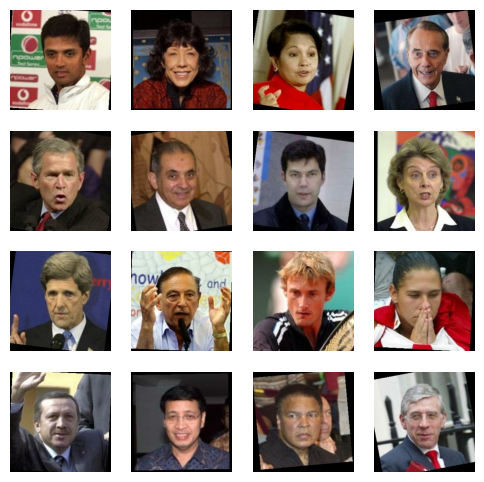

In [4]:
# Data Visualization
side = 4
for batch in x_train.take(1):
    plt.figure(figsize=(6, 6))
    for i, image in enumerate(batch[:side*side]):
        ax = plt.subplot(side, side, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

In [5]:
# generate dataset of noisy images

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def add_noise_preprocessing(image):
    if np.random.random() > 1.0: # only add noise % of times
        return image
    # Add random noise
    noise_factor = 0.3 + 0.4 * np.random.random()
    image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)

    # Clip the values to be in the valid image range [0, 1]
    return np.clip(image, 0.0, 1.0)

def add_pixles_preprocessing(image):
    if np.random.random() > 0.8: # only add pixles % of times
        return image
    # Add random pixels
    num_pixels = np.random.randint(0, 1 + int( 500 * np.random.random()))
    for _ in range(num_pixels):
        x = np.random.randint(0, image.shape[0])
        y = np.random.randint(0, image.shape[1])
        image[x, y, :] = np.random.rand()

    return image

def custom_preprocessing(image):
    image = add_noise_preprocessing(image)
    image = add_pixles_preprocessing(image)
    return image


# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(
    rotation_range=0,      # Randomly rotate images by 20 degrees
    width_shift_range=0.0,  # Randomly shift images horizontally by 10%
    height_shift_range=0.0, # Randomly shift images vertically by 10%
    shear_range=0.0,        # Apply shear transformation
    zoom_range=0.0,         # Randomly zoom into images
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest',    # Fill in missing pixels with the nearest value
    preprocessing_function=custom_preprocessing
)

# Function to apply data augmentation using the .flow() method
def apply_data_augmentation(image):
    augmented_images = datagen.flow(image, batch_size=len(batch), shuffle=False)
    return next(augmented_images)


x_train_noisy = x_train.map(lambda x: (x, tf.numpy_function(apply_data_augmentation, [x], tf.float32)))
x_val_noisy = x_val.map(lambda x: (x, tf.numpy_function(apply_data_augmentation, [x], tf.float32)))
x_train_small_noisy = x_train_small.map(lambda x: (x, tf.numpy_function(apply_data_augmentation, [x], tf.float32)))

print('shape of train input dataset:  ', x_train)
print('shape of train perturbed dataset: ', x_train_noisy)
print('\nshape of val input dataset:  ', x_val)
print('shape of val perturbed dataset: ', x_val_noisy)

shape of train input dataset:   <_MapDataset element_spec=TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None)>
shape of train perturbed dataset:  <_MapDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

shape of val input dataset:   <_MapDataset element_spec=TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None)>
shape of val perturbed dataset:  <_MapDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>


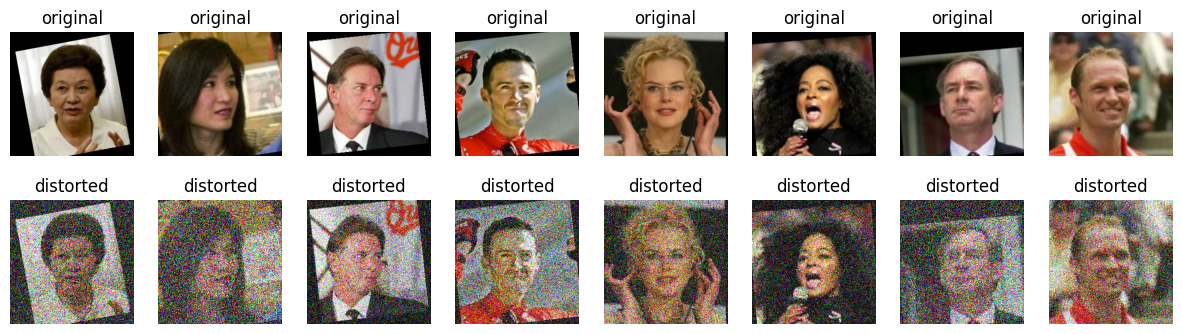

In [6]:
# Preview examples of distortion
num_preview = 8
fig, ax = plt.subplots(2, num_preview, figsize=(15, 4))

for batch1, batch2 in x_train_noisy.take(1):
    for i, (image1, image2) in enumerate(zip(batch1, batch2)):
        if i >= num_preview:
            break
        ax[0, i].imshow(image1)
        ax[0, i].axis('off')
        ax[0, i].set_title('original')

        ax[1, i].imshow(image2)
        ax[1, i].axis('off')
        ax[1, i].set_title('distorted')

plt.show()

## Model

In [7]:
input_shape = (250, 250, 3)

model_encoder = tf.keras.models.Sequential()
model_encoder.add(tf.keras.layers.Input(shape=input_shape))
model_encoder.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_encoder.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
model_encoder.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_encoder.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

model_decoder = tf.keras.models.Sequential()
model_decoder.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
model_decoder.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
model_decoder.add(tf.keras.layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='valid'))

model_encdec = tf.keras.models.Sequential([model_encoder, model_decoder])

model_encdec.build(input_shape=(None, *input_shape)) # 'None' did specify an abitrary batch size

model_encdec.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 63, 63, 16)        5520      
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       7827      
                                                                 
Total params: 13347 (52.14 KB)
Trainable params: 13347 (52.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model_encdec.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

time_at_training_start = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model/best_model_{time_at_training_start}.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


history = model_encdec.fit(
    x_train_small_noisy if use_small_training_data else x_train_noisy,
    epochs=10,
    shuffle=True,
    validation_data=x_val_noisy,
    callbacks=[callback, checkpoint]
)

shutil.copy(f"model/best_model_{time_at_training_start}.keras", "model/best_model.keras")

Epoch 1/10
290/290 [==============================] - ETA: 0s - loss: 0.1088
Epoch 1: val_loss improved from inf to 0.10608, saving model to model/best_model_20240114_092740.keras
290/290 [==============================] - 121s 388ms/step - loss: 0.1088 - val_loss: 0.1061
Epoch 2/10
290/290 [==============================] - ETA: 0s - loss: 0.1056
Epoch 2: val_loss improved from 0.10608 to 0.10443, saving model to model/best_model_20240114_092740.keras
290/290 [==============================] - 110s 377ms/step - loss: 0.1056 - val_loss: 0.1044
Epoch 3/10
290/290 [==============================] - ETA: 0s - loss: 0.1054
Epoch 3: val_loss did not improve from 0.10443
290/290 [==============================] - 109s 374ms/step - loss: 0.1054 - val_loss: 0.1055
Epoch 4/10
290/290 [==============================] - ETA: 0s - loss: 0.1050
Epoch 4: val_loss improved from 0.10443 to 0.10399, saving model to model/best_model_20240114_092740.keras
290/290 [==============================] - 110s 3

'model/best_model.keras'

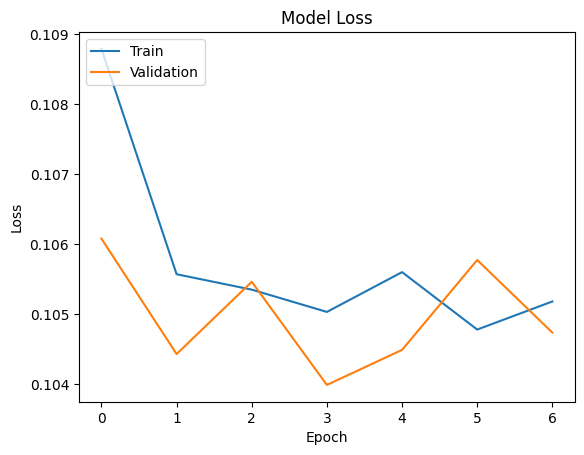

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Predict Image

In [10]:
model_encdec = tf.keras.models.load_model(f'model/best_model.keras')

In [11]:
def preview_decoding(model, x_input, n):
    fig, axes = plt.subplots(3, n, figsize=(n*2 + 2, 7))
    for batch1, batch2 in x_input.take(1):
        for i, (image1, image2) in enumerate(zip(batch1, batch2)):
            if i >= num_preview:
                break
            prediction = model.predict(np.array([image1]))

            axes[0][i].imshow(image2)
            axes[0][i].set_title('Noisy Input')
            axes[0][i].axis('off')

            axes[1][i].imshow(prediction[0])
            axes[1][i].set_title('Decoded Image')
            axes[1][i].axis('off')

            axes[2][i].imshow(image1)
            axes[2][i].set_title('Target')
            axes[2][i].axis('off')
    plt.show()

1/1 [==============================] - 0s 19ms/step


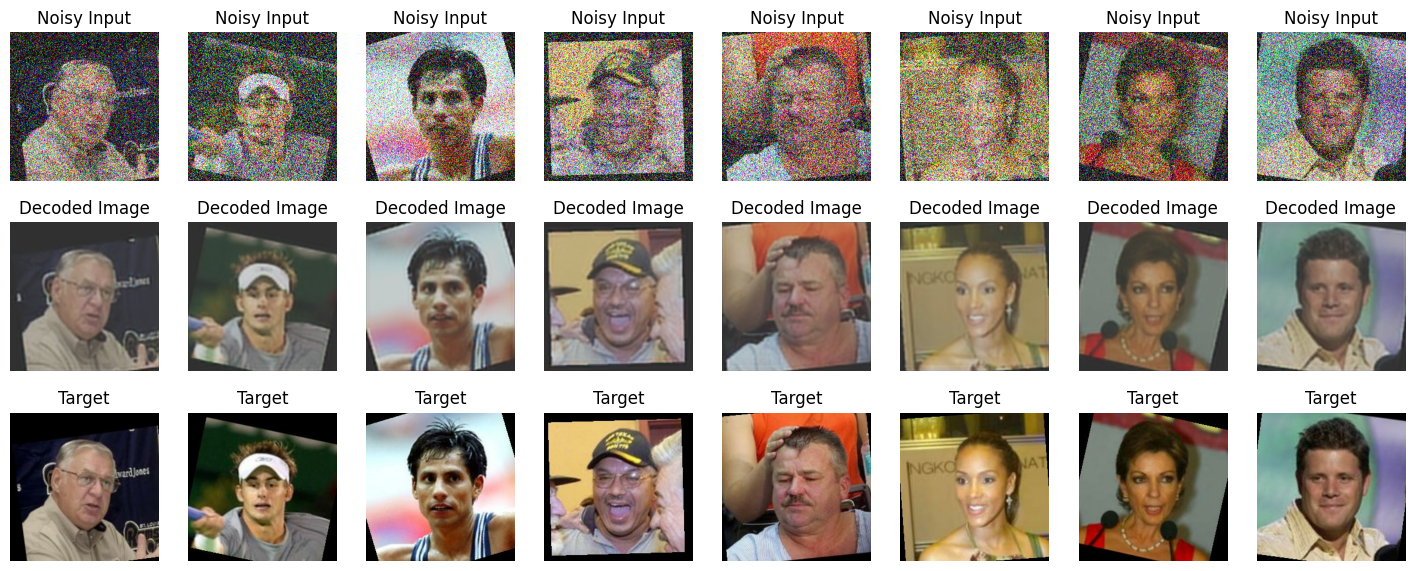

In [12]:
# Decoding validation data
preview_decoding(model_encdec, x_val_noisy, 8)

1/1 [==============================] - 0s 19ms/step


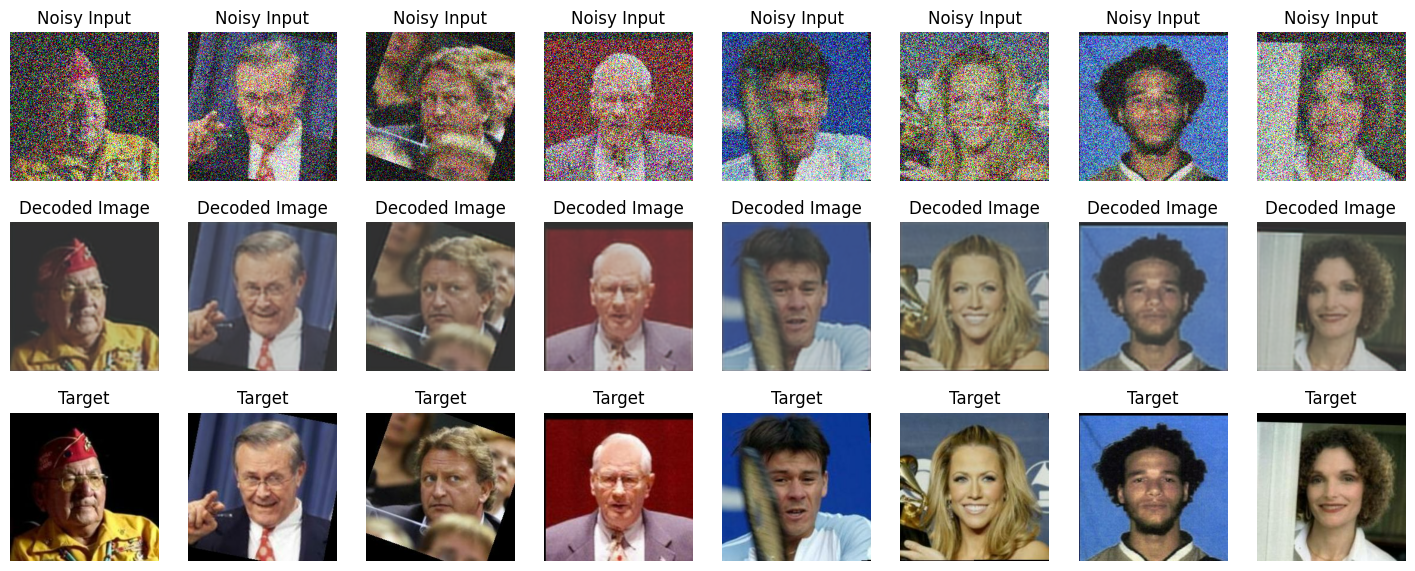

In [13]:
# Decoding TRAINING data as a comparison
preview_decoding(model_encdec, x_train_noisy, 8)